In [1]:
import pandas as pds
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:
all_data_df = pds.read_csv("Biosample_all.tsv.gz", sep="\t")

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,14,16,18,19,23,26,27,28,29,30,34,35,36,37,39,41,42,43,44,45,52,57,62,70,72,73,76,77,78,79,86,98,99,100,103,104,105,106,111,119,124,133,134,135,142,144,146,149,165,191,208,229,233,252,253,254) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
elevels = ['ECOSYSTEM', 'ECOSYSTEM_CATEGORY', 'ECOSYSTEM_TYPE', 'ECOSYSTEM_SUBTYPE', 'SPECIFIC_ECOSYSTEM']
elevelsdf = all_data_df[elevels]

In [4]:
elevelsdf.head()

,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM
0,Host-associated,Plants,Phyllosphere,Caulosphere,NaN
1,Engineered,Food production,Dairy products,NaN,NaN
2,Engineered,Food production,Dairy products,NaN,NaN
3,Engineered,Food production,Dairy products,NaN,NaN
4,Engineered,Food production,Dairy products,NaN,NaN


## High level description of data
Most of the samples are from the gut

In [5]:
elevelsdf.describe()

,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM
count,64033,64033,64030,48921,34600
unique,3,38,118,130,101
top,Host-associated,Human,Digestive system,Large intestine,Fecal
freq,30868,19719,21492,16718,16781


## Get unique counts for each ecosystem
* Is there a distinction between values 'unclassified' and null?
* What is the difference between 'ECOSYSTEM_CATEGORY' and 'ECOSYSTEM_TYPE'

In [6]:
elevelsdf.groupby('ECOSYSTEM').count()

,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM
ECOSYSTEM,,,,
Engineered,5211,5211,3189,2849
Environmental,27954,27954,21462,10683
Host-associated,30868,30865,24270,21068


## Build EAV table and get unique counts

In [7]:
## give the index column a name and reset
elevelsdf.index.name = 'id'
elevelsdf.reset_index(inplace=True)
elevelsdf.head()

,id,ECOSYSTEM,ECOSYSTEM_CATEGORY,ECOSYSTEM_TYPE,ECOSYSTEM_SUBTYPE,SPECIFIC_ECOSYSTEM
0,0,Host-associated,Plants,Phyllosphere,Caulosphere,NaN
1,1,Engineered,Food production,Dairy products,NaN,NaN
2,2,Engineered,Food production,Dairy products,NaN,NaN
3,3,Engineered,Food production,Dairy products,NaN,NaN
4,4,Engineered,Food production,Dairy products,NaN,NaN


In [8]:
## use melt function to unpivot/unstack the data
eavdf = elevelsdf.melt(id_vars='id')
eavdf.sort_values(by=['id'], inplace=True)
print(pds.DataFrame(elevelsdf.iloc[5046])) ## print a random record from the original df and eav to make sure they values match
print(eavdf[eavdf.id == 5046])

                                5046
id                              5046
ECOSYSTEM            Host-associated
ECOSYSTEM_CATEGORY             Human
ECOSYSTEM_TYPE      Digestive system
ECOSYSTEM_SUBTYPE    Large intestine
SPECIFIC_ECOSYSTEM             Fecal
          id            variable             value
5046    5046           ECOSYSTEM   Host-associated
197478  5046   ECOSYSTEM_SUBTYPE   Large intestine
261622  5046  SPECIFIC_ECOSYSTEM             Fecal
133334  5046      ECOSYSTEM_TYPE  Digestive system
69190   5046  ECOSYSTEM_CATEGORY             Human


In [9]:
q = """
select 
    variable, value, count(*) as total
from 
    eavdf
group by 
    variable, value
order by 
    variable, total desc
"""
totalsdf = pysqldf(q)
totalsdf.head(10)

,variable,value,total
0,ECOSYSTEM,Host-associated,30868
1,ECOSYSTEM,Environmental,27954
2,ECOSYSTEM,Engineered,5211
3,ECOSYSTEM,None,111
4,ECOSYSTEM_CATEGORY,Human,19719
5,ECOSYSTEM_CATEGORY,Aquatic,19622
6,ECOSYSTEM_CATEGORY,Terrestrial,8214
7,ECOSYSTEM_CATEGORY,Mammals,4151
8,ECOSYSTEM_CATEGORY,Plants,3467
9,ECOSYSTEM_CATEGORY,Built environment,1890


## Pivot totalsdf for displying figures

In [10]:
pds.set_option('display.max_columns', 1000)
pivotdf = totalsdf.pivot(index='variable', columns='value', values='total')
pivotdf

value,nan,Abyssal plane,Acid Mine Drainage,Acidic,Activated Sludge,Activated sludge,Aerobic,Aerobic media,Agricultural,Agricultural Soil,Agricultural field,Agricultural land,Agricultural soil,Air,Algae,Alkaline,Anaerobic,Anaerobic digestor,Anaerobic media,Anammox,Animal,Annelida,Ant dump,Anthosphere,Aphotic zone,Aquaculture,Aquatic,Aquifer,Arthropoda,Ascidians,Asphalt lakes,Asteroidea,Athalassic,Attached/Keratinized gingiva,Bacteria,Bacteriomes,Beach,Beetle,Benthic,Benzene,Bioanode,Biocathode,Biochar,Biofilm,Biological phosphorus removal,Bioreactor,Bioremediation,Biotransformation,Birds,Black smokers,Blood,Bog,Bone,Brain,Breviatea,Brown Algae,Built environment,Canal,Carposphere,Caulosphere,Cave,Cave water,Ceca,Cecum,Chloroethene,Circulatory system,City,Clay,Cloaca,Cnidaria,Coalbed water,Coastal,Cold seeps,Composting,Contaminated,Continuous culture,Copepoda,Coral,Coral reef,Cow Dung,Creek,Crop,Crustacea,Crustal Fluids,Ctenophora,Currency notes,Cuticle,Dairy products,Deep subsurface,Defined media,Delivery networks,Desert,Diatoms,Diffuse flow,Digestive system,Digestive tube,Dinoflagellates,Dissolved organics (aerobic),Dissolved organics (anaerobic),Drainage pipe biofilm,Drinking water,Duodenal,Dust,Echinodermata,Ectosymbionts,Ectosymbionts,Egg capsule,Endoperitrophic space,Endophytes,Endosphere,Endosymbionts,Engineered,Engineered product,Environmental,Epibionts,Epidermal mucus,Epilimnion,Epiphytes,Estuary,Extracellular,Extracellular symbionts,Eye,Fecal,Fermented beverages,Fermented vegetables,Fish,Floodplain,Food production,Foregut,Forest Soil,Forest soil,Fossil,Fracking water,Freshwater,Fruiting body,Fumaroles,Fungi,Fungus gallery,Fungus garden,Garden dump,Gastrointestinal tract,Geologic,Gills,Glacial lake,Glacier,Grass,Grasslands,Green algae,Groundwater,Gulf,Gut,Hair,Haptophytes,Harbor,Hindgut,Hospital,Host-associated,Hot (42-90C),House,Human,Hydrocarbon,Hydrothermal vents,Hypersaline,Hypolimnion,Ice,Ice accretions,Indoor Air,Industrial production,Industrial wastewater,Inlet,Insecta,Integument,Intertidal zone,Intestine,Intracellular,Intracellular endosymbionts,Introitus,Invertebrates,Lab enrichment,Lab synthesis,Lake,Landfill,Large intestine,Larvae,Leaf,Leaf surface,Lentic,Lichen,Limnetic zone,Littoral zone,Loam,Lotic,Low land river systems,Lumen,Lymph nodes,Lymphatic system,Mammals,Marginal Sea,Marine,Marine intertidal flat sediment inoculum,Marine media,Marine sediment inoculum,Meat products,Medial distal leg,Metal,Methane,Microbial,Microbial enhanced oil recovery,Microbial mats,Microbial solubilization of coal,Microbialites,Midgut,Midpoint vagina,Milk,Mine,Mine drainage,Mine water,Mixed alcohol bioreactor,Modeled,Mollusca,Mosquito,Mud volcano,Mycelium,Naris,Nasal cavity,Nasopharyngeal,Near-boiling (>90C),Nematoda,Neritic zone,Nervous system,Neutral,Nitrogen removal,Nodule,Non-marine Saline and Alkaline,Nutrient removal,Oceanic,Oceanic crust,Oil refinery,Oil reservoir,Oil seeps,Oil well,Oil-contaminated,Oil-contaminated sediment,Oral,Outdoor Air,Ovaries,P1 segment,P3 segment,Palatine tonsils,Paper,Park,Peat,Peat moss,Pelagic,Periodontal pockets,Permafrost,Persistent organic pollutants (POP),Petrochemical,Petroleum sludge,Pharynx,Photic zone,Phylloplane,Phyllosphere,Plant litter,Plants,Plasma,Pollen,Polycyclic aromatic hydrocarbons,Pond,Ponds,Porifera,Primary,Proctodeal segment,Protists,Pulmonary system,Rectum,Red algae,Reproductive system,Reptilia,Respiratory system,Rhizoplane,Rhizosphere,River,Rock-dwelling (endoliths),Rock-dwelling (subaerial biofilms),Roots,Rumen,Saline,Saliva,Salt crystallizer ponds,Salt marsh,Sand,Sanger,Sclerotium,Sea Star,Seaweed,Secondary,Sediment,Seeds,Serum,Shell,Shrubland,Sigmoid colon,Silt,Simulated communities (DNA mixture),Simulated communities (microbial mixture),Simulated communities (sequence read mixture),Skin,Slime,Small intestine,Soil,Soil crust,Solar panel,Solid animal waste,Solid waste,Spacecraft Assembly Cleanrooms,Sponge,Sputum,Stomach,Storm water,Strait,Subgingival plaque,Subglacial l

### Display stacked bar chart of values in each elevel

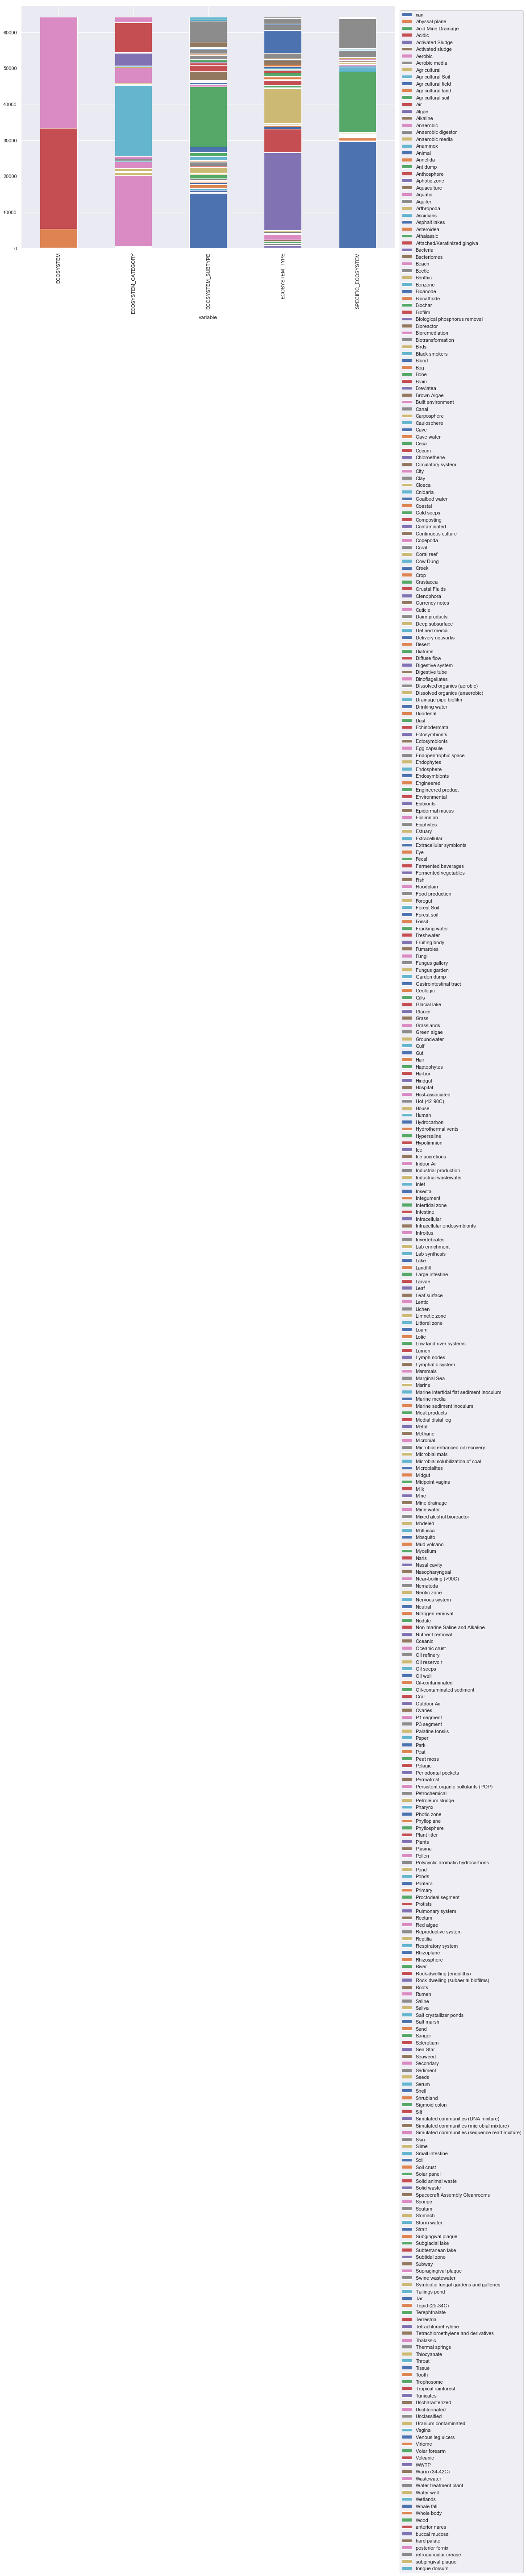

In [11]:
sns.set() # use seaborn styles
pivotdf.plot.bar(stacked=True, figsize=(15, 10))
plt.legend(loc='best', bbox_to_anchor=(1, 1), borderaxespad=1)
plt.show()

## Display heatmap of elevels

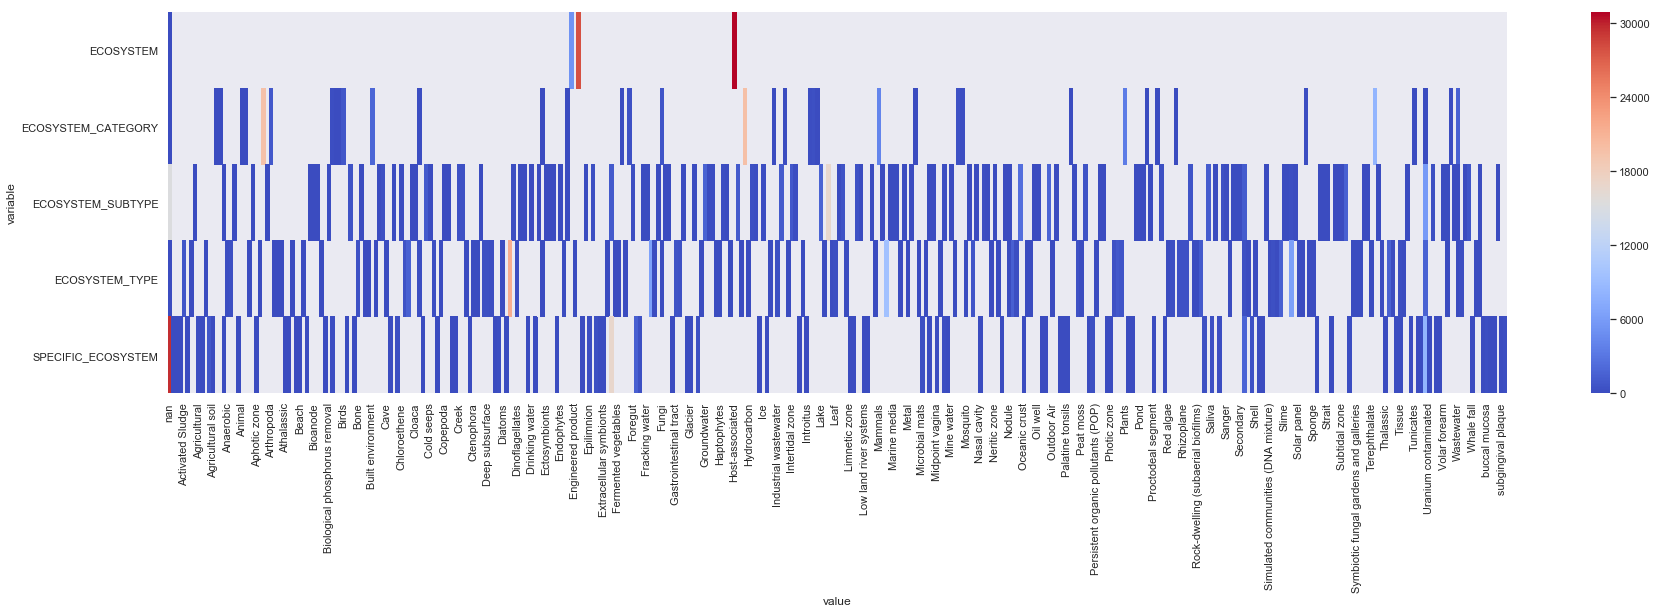

In [12]:
sns.set() # use seaborn styles
plt.figure(figsize = (30,7)) # this sets width and height of the figure
ax = sns.heatmap(pivotdf, cmap='coolwarm')
plt.show()

### Above charts are hard to read, but it looks like there are a max of roughly 7 major clustering. So, look at those.

In [13]:
q = """
WITH TOPTEN AS (
    SELECT *, ROW_NUMBER() 
    over (
        PARTITION BY variable
        order by total desc
    ) AS RowNo 
    FROM totalsdf
)
SELECT * FROM TOPTEN WHERE RowNo <= 7
"""
top7_totalsdf = pysqldf(q)
top7_totalsdf

,variable,value,total,RowNo
0,ECOSYSTEM,Host-associated,30868,1
1,ECOSYSTEM,Environmental,27954,2
2,ECOSYSTEM,Engineered,5211,3
3,ECOSYSTEM,None,111,4
4,ECOSYSTEM_CATEGORY,Human,19719,1
5,ECOSYSTEM_CATEGORY,Aquatic,19622,2
6,ECOSYSTEM_CATEGORY,Terrestrial,8214,3
7,ECOSYSTEM_CATEGORY,Mammals,4151,4
8,ECOSYSTEM_CATEGORY,Plants,3467,5
9,ECOSYSTEM_CATEGORY,Built environment,1890,6


### Becuase of repeating values, and a special "annotated value" column that the concatenation of the variable and value columns
e.g., "ECOSYSTEM" + "Host-associated" -> "ECOSYSTEM: Host-associated"
This helps make the stacked bar chart more readable

In [14]:
def format_eav_value(variable, value):
    if pds.isna(value):
        return value
    else:
        return variable + ": " + str(value)
    
top7_totalsdf['annotated_value'] = top7_totalsdf.apply(lambda row: format_eav_value(row['variable'], row['value']), axis=1)

In [15]:
stackeddf = top7_totalsdf[['variable', 'annotated_value', 'total']].pivot(index='variable', columns='annotated_value', values='total')
stackeddf

annotated_value,nan,ECOSYSTEM: Engineered,ECOSYSTEM: Environmental,ECOSYSTEM: Host-associated,ECOSYSTEM_CATEGORY: Aquatic,ECOSYSTEM_CATEGORY: Built environment,ECOSYSTEM_CATEGORY: Human,ECOSYSTEM_CATEGORY: Mammals,ECOSYSTEM_CATEGORY: Plants,ECOSYSTEM_CATEGORY: Terrestrial,ECOSYSTEM_CATEGORY: Wastewater,ECOSYSTEM_SUBTYPE: Groundwater,ECOSYSTEM_SUBTYPE: Lake,ECOSYSTEM_SUBTYPE: Large intestine,ECOSYSTEM_SUBTYPE: Oceanic,ECOSYSTEM_SUBTYPE: Oral,ECOSYSTEM_SUBTYPE: Unclassified,ECOSYSTEM_TYPE: City,ECOSYSTEM_TYPE: Digestive system,ECOSYSTEM_TYPE: Freshwater,ECOSYSTEM_TYPE: Marine,ECOSYSTEM_TYPE: Soil,ECOSYSTEM_TYPE: Thermal springs,ECOSYSTEM_TYPE: Unclassified,SPECIFIC_ECOSYSTEM: Agricultural land,SPECIFIC_ECOSYSTEM: Fecal,SPECIFIC_ECOSYSTEM: Forest Soil,SPECIFIC_ECOSYSTEM: Sediment,SPECIFIC_ECOSYSTEM: Serum,SPECIFIC_ECOSYSTEM: Unclassified
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ECOSYSTEM,111.0,5211.0,27954.0,30868.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECOSYSTEM_CATEGORY,NaN,NaN,NaN,NaN,19622.0,1890.0,19719.0,4151.0,3467.0,8214.0,1478.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECOSYSTEM_SUBTYPE,15223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1571.0,1579.0,16718.0,2424.0,1745.0,5805.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ECOSYSTEM_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1464.0,21492.0,6393.0,9571.0,6280.0,1523.0,1585.0,NaN,NaN,NaN,NaN,NaN,NaN
SPECIFIC_ECOSYSTEM,29544.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725.0,16781.0,1328.0,1763.0,374.0,8211.0


### Display stacked bar chart

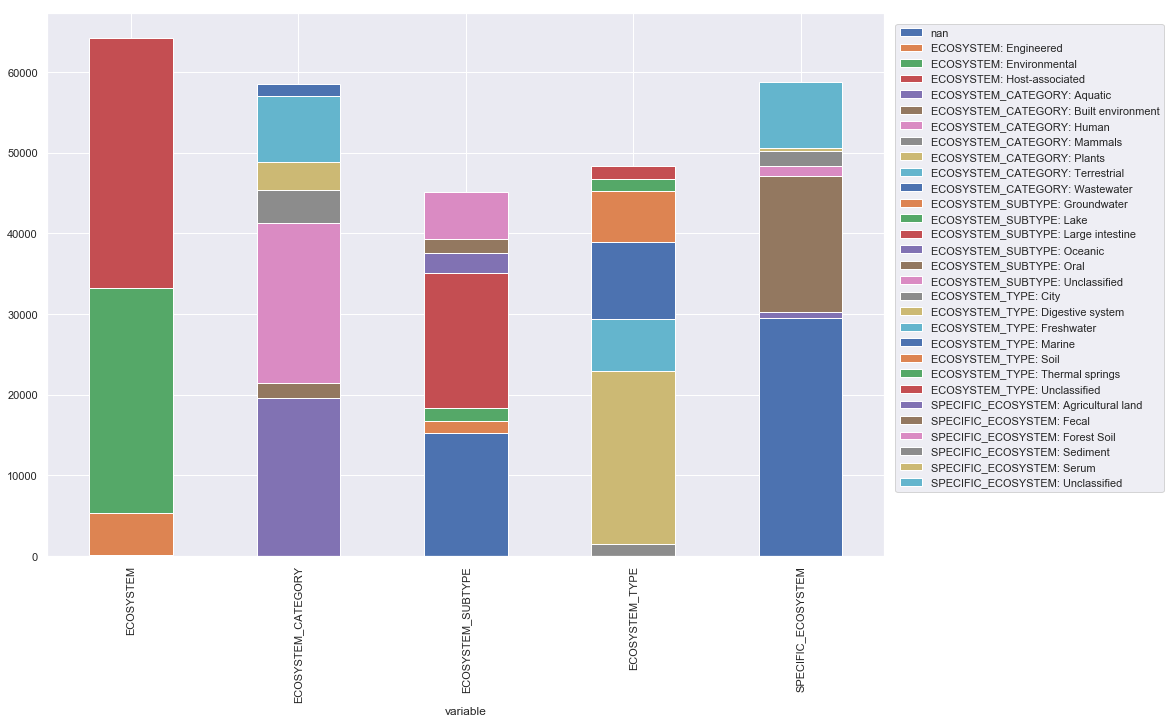

In [16]:
sns.set() # use seaborn styles
stackeddf.plot.bar(stacked=True, figsize=(15, 10))
plt.legend(loc='best', bbox_to_anchor=(1, 1), borderaxespad=1)
plt.show()

### Build a heatmap of the data, for this I won't be using the annotated values

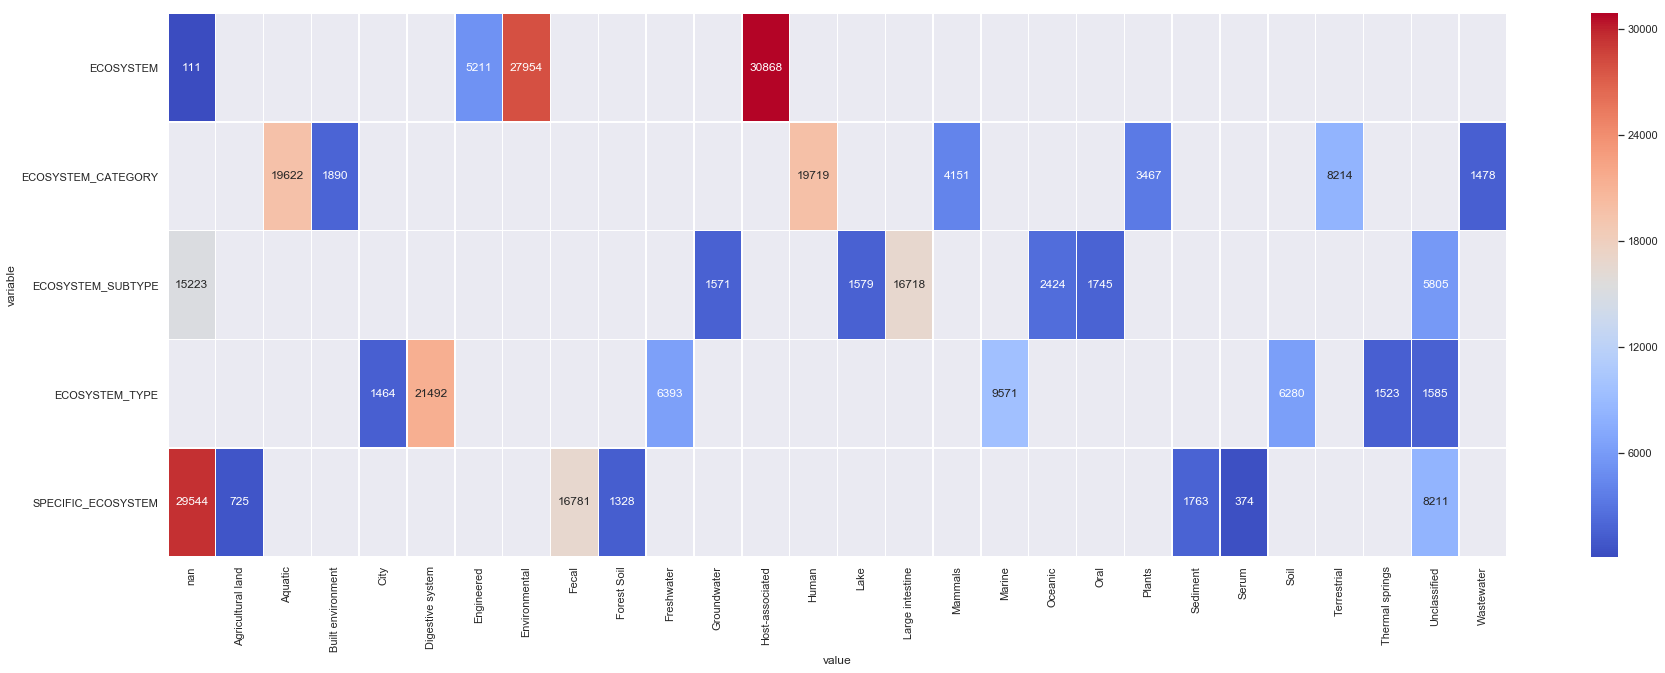

In [17]:
heatdf = top7_totalsdf[['variable', 'value', 'total']].pivot(index='variable', columns='value', values='total')

sns.set() # use seaborn styles
plt.figure(figsize = (30,10)) # this sets width and height of the figure

# fmt='.0f' means annotations are floats rounded to zero decimal places
ax = sns.heatmap(heatdf, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".0f")
plt.show()

### Take aways
* ECOSYSTEM: Mostly Environment and Host-associated samples
* ECOSYSTEM_CATAGORY: Mostly Acquatic and Human samples; fair amount of terrestrial samples
* ECOSYSTEM_TYPE: Mostly Digestive system samples; fair amount of fresh water, marine, and Thermal spring samples
* ECOSYSTEM_SUBTYPE: Mostly Large intesting samples; Lots of Unclassified and NaN; Some Groundwater, Lake, and Oceanic
* SPEFIC_ECOSYSTEM: Mostly NaN and Unclassified samples; fair amount of Fecal samples


## Build graph of data to explore connections

In [18]:
## create EAV table containing only top 7 values
q = """
select 
    *
from 
    eavdf
where value in 
    (select distinct value from top7_totalsdf)
"""
top7_eavdf = pysqldf(q)
top7_eavdf.head(10)

,id,variable,value
0,0,ECOSYSTEM,Host-associated
1,0,ECOSYSTEM_CATEGORY,Plants
2,1,ECOSYSTEM,Engineered
3,2,ECOSYSTEM,Engineered
4,3,ECOSYSTEM,Engineered
5,4,ECOSYSTEM,Engineered
6,5,ECOSYSTEM,Engineered
7,6,ECOSYSTEM,Engineered
8,7,ECOSYSTEM_TYPE,Freshwater
9,7,ECOSYSTEM,Environmental


### Let's look at the first 10 records (ids 0-9)

In [19]:
g1 = nx.from_pandas_edgelist(top7_eavdf[top7_eavdf.id < 10], 'id', 'value', edge_attr='variable', create_using=nx.DiGraph())

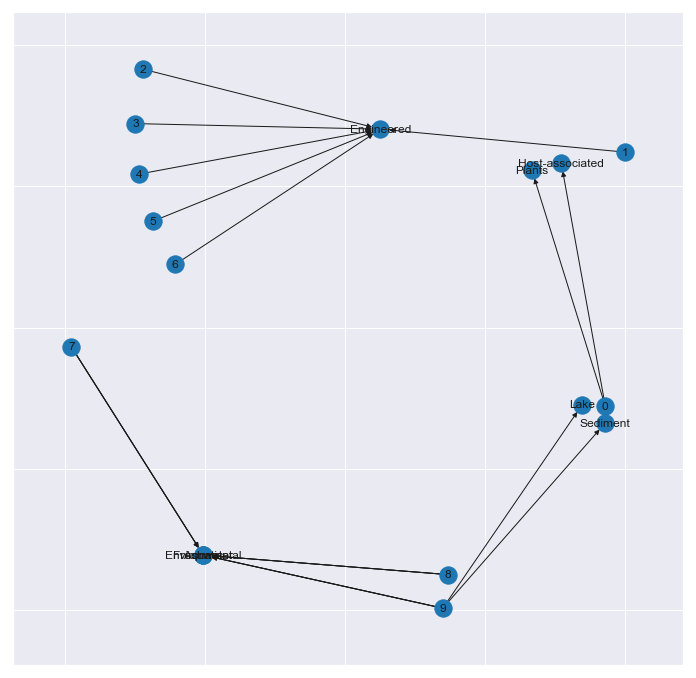

In [20]:
plt.figure(figsize=(12, 12))
nx.draw_networkx(g1, with_labels=True, pos=nx.kamada_kawai_layout(g1))